Given presentation is not actually done uniformly, switch to a training regimen more closely resembling the experiment:

- **Presentation Block**: all pairs are presented once
- **Learning block 1**: fan 1 pairs are presented twice, fan 2 pairs 5 times. (order randomized)
- **Learning block 2,3,4**: fan 1 pairs are presented once, fan 2 pairs twice.

Jelmer also used surprising parameters, including:
- Intercepts uniformly distributed between 0. and .1
- 512 Dimensions
- 1k neurons

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple
from typing import List

import random

# Setup

In [3]:
n_items = 16
dimensions = 32
n_neurons = 1000

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [4]:
n_repeats = 1
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)

intercepts = nengo.dists.Uniform(0, .1).sample(n_neurons)

In [5]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [6]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [97]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

# Train

In [98]:
def learn_network(feed_vecs: List[np.array],
                  start_enc: np.array, start_dec: np.ndarray,
                  voja_lr=5e-8, pes_lr=5e-4) -> np.array:
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as model:
        in_nd = nengo.Node(feed.feed)
        correct = nengo.Node(feed.get_answer)
        nvoja_learn = nengo.Node(lambda t: 1-feed.paused)
        learning = nengo.Node(lambda t: -feed.paused)
        paused = nengo.Node(lambda t: feed.paused)
        output = nengo.Node(size_in=dimensions)

        neg_voja = NegVoja(start_enc.copy(), learning_rate=voja_lr)
        ens = nengo.Ensemble(n_neurons, dimensions, seed=seed)

        nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

        nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
        nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
        nengo.Connection(nvoja_learn, neg_voja.enable, synapse=None)
        nengo.Connection(neg_voja.output, ens.neurons, synapse=None)
        
        conn_out = nengo.Connection(ens.neurons, output, transform=start_dec,
                                    learning_rule_type=nengo.PES(pes_lr))
        
        # Error flow node
        pes_learn_control = nengo.Node(
            lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
            size_in=dimensions + 1)
        nengo.Connection(pes_learn_control,
                         conn_out.learning_rule)

        # Error calculation connections
        nengo.Connection(output, pes_learn_control[:-1],
                         synapse=None)
        nengo.Connection(correct, pes_learn_control[:-1],
                         transform=-1, synapse=None)
        # Control connection
        nengo.Connection(learning, pes_learn_control[-1],
                         synapse=None)

        p_in = nengo.Probe(in_nd)
        p_cor = nengo.Probe(correct, synapse=None)
        p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
        p_out = nengo.Probe(output, synapse=0.01)

    with nengo.Simulator(model) as sim:
        sim.run(len(feed_vecs)*t_each + t_pause)
    
    return neg_voja.encoder_hist[-1].copy(), sim.data[p_dec][-1]

In [99]:
def shuffle_list(li: List):
    return sorted(li, key=lambda k: random.random())

In [100]:
all_feed_vecs = (
    (fan1_pair_vecs + fan2_pair_vecs, 1e-4),
    (shuffle_list(fan1_pair_vecs * 2 + fan2_pair_vecs * 5), 5e-5),
    (shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3), 5e-5),
    (shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3), 1e-4),
    (shuffle_list(fan1_pair_vecs + fan2_pair_vecs * 3), 1e-2))

In [101]:
dec = np.zeros((dimensions, n_neurons))

for f_v, p_lr in all_feed_vecs:
    enc, dec = learn_network(f_v, enc, dec, pes_lr=p_lr)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Verification

In [102]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [103]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

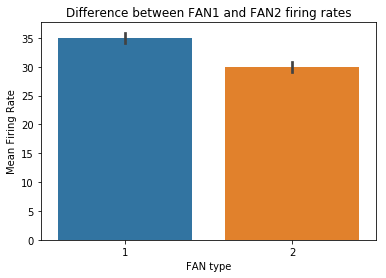

In [104]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

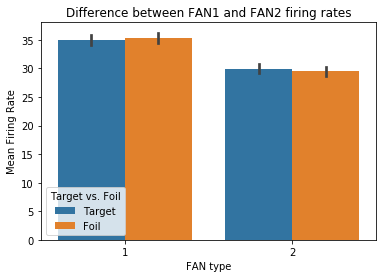

In [105]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

## Test PES

In [106]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [107]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [108]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

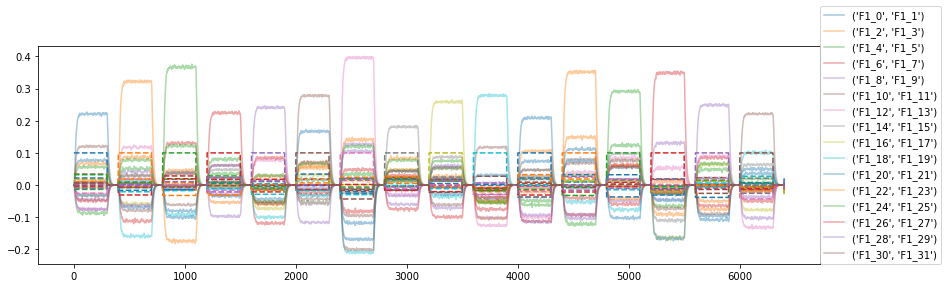

In [109]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

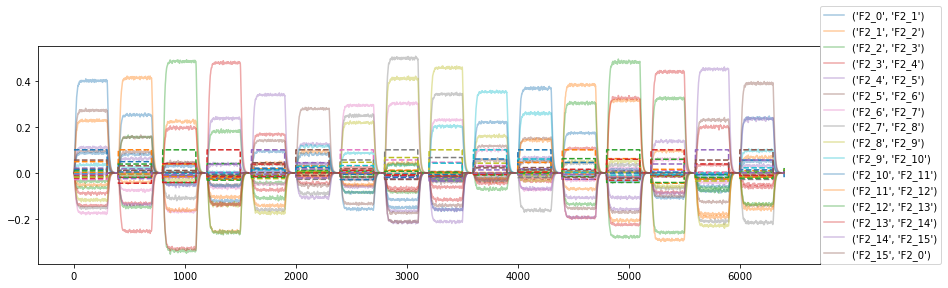

In [110]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

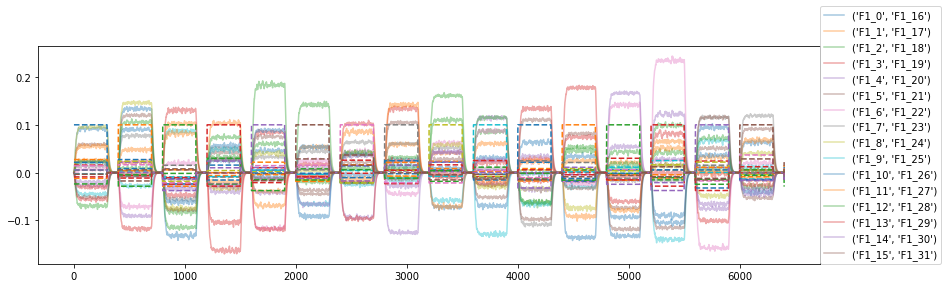

In [111]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [112]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [113]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [114]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [115]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[  65.69427199   95.85593608  109.10621966   66.71801006   71.61124265
   82.91631573  117.87558073   53.80529794   76.90389391   83.00931603
   62.0453253   104.68769784   86.60380053  103.88275711   74.04050266
   65.93991021]
82.5435049021


In [116]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [117]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 118.931513    122.92567107  144.02885558  142.11279864  100.86276055
   82.60654857   87.20279108  148.26556943  135.7764068   104.78338774
  109.2502483   113.73344667  143.1331061   130.44517315  133.87141587
  115.31601993]
120.82785703


## Compare reaction times

In [118]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [119]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [120]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 78.3989505237
fan2 114.720878714
foil1 55.9484751143
foil2 80.9946290294


In [121]:
conf_df = pd.DataFrame(confs)

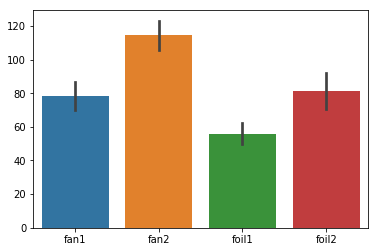

In [122]:
sns.barplot(data=conf_df)

Learning with recurrence works from decoding function 0, but never fully differentiating FAN1 vs FAN2. learning without recurrence does a worse job of seperating foils from targets. Learning from initial decoding works really poorly.